# Programming Assingnment3 - Implementation of Transformer Part 1

안녕하세요 **AIKU 학회원 여러분**, 세 번째 과제랑 다음주에 나오는 네 번째 과제는 연계되는 과제로, Transformer 모델 전체를 직접 구현해보는 AIKU만의 Mini Term Project입니다. Transformer 모델은 NLP의 핵심 구조이므로, 이를 직접 구현하는 과정을 통해 언어 모델을 더 깊이 이해하고, 향후 Pytorch를 사용하여 모델을 구현할 때 큰 도움이 될 것입니다.

모든 코드를 처음부터 구현하는 것은 매우 어려우므로, 각 함수와 클래스에 대한 설명을 docstring 형태로 제공해드렸습니다. 과제가 어려울 수 있지만, 여러분이 충분히 해낼 수 있도록 최선을 다해 도와드리겠습니다. 혹여나 오류가 있거나 과제 관련 문의사항이 있다면 주니어 무물딥 오픈카톡방 또는 과제 출제자인 부학회장한테 편하게 말해주세요! 이번주 및 다음주 과제를 성공적으로 수행한다면, 실력 향상은 장담할 수 있으니 부디 열심히 풀기를 바라겠습니다.

이번 주에 여러분이 구현할 부분은 Transformer의 Encoder로, 이를 사용하여 IMDB 데이터셋에 대해 텍스트 분류 작업을 수행할 예정입니다.

다음 자료를 참고하셔도 좋습니다:
[딥러닝을 이용한 자연어처리 입문 - Transformer](https://wikidocs.net/31379)

![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/transformer-model-architecture.png)

## Part 1. 준비

### 1-1. Pip install & Imports
필요한 패키지를 pip를 이용해서 설치합니다.

In [ ]:
!pip install torchdata torchtext spacy portalocker matplotlib seaborn wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=a048426b92ff626dfbf3c2da904e77ddedf1817e1c81c07cdaa966922c5c61c2
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


필요한 라이브러리를 import하고, device를 GPU로 바꿔줍니다.

다만, 코드를 구현하는 과정에서는 **CPU 사용**을 권장드립니다.

GPU가 가장 많이 필요한 단계는 학습하는 과정인데 구현하는 시간동안 colab의 GPU를 다 써버리면 막상 학습할 때 필요한 GPU 자원을 쓸 수 없게 됩니다. 따라서 코드를 모두 구현하고 train 코드가 잘 돌아가는지 확인한 뒤에 colab 상단 런타임 메뉴에서 런타임 유형을 GPU로 바꾼 뒤에 실행하면 됩니다.

In [ ]:
import os
import random
import torch
import torch.nn.functional as F
from torch import nn
from torch import nn, Tensor


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print('using device: ', device)

using device:  cuda


## Part 2. Transformer Architecture

Transformer에 대해서 배우기 전에 기존의 seq2seq를 상기해봅시다. 기존의 seq2seq 모델은 encoder-decoder 구조로 구성되어져 있었습니다. 여기서 encoder는 입력 시퀀스를 하나의 벡터 표현으로 압축하고, decoder는 이 벡터 표현을 통해서 출력 시퀀스를 만들어냈습니다. 하지만 이러한 구조는 encoder가 입력 시퀀스를 하나의 벡터로 압축하는 과정에서 입력 시퀀스의 정보가 일부 손실된다는 단점이 있었고, 이를 보정하기 위해 attention이 사용되었습니다. 그런데 attention을 RNN의 보정을 위한 용도로서 사용하는 것이 아니라 attention만으로 encoder와 decoder를 만들어보면 어떨까요?

![](https://wikidocs.net/images/page/31379/transformer1.PNG)

Transformer는 RNN을 사용하지 않지만 기존의 seq2seq처럼 encoder에서 입력 시퀀스를 입력받고, decoder에서 출력 시퀀스를 출력하는 encoder-decoder 구조를 유지하고 있습니다. 이전 seq2seq 구조에서는 encoder와 decoder에서 각각 하나의 RNN이 t개의 시점(time step)을 가지는 구조였다면 이번에는 encoder와 decoder라는 단위가 N개로 구성되는 구조입니다. Transformer를 제안한 논문에서는 encoder와 decoder의 개수를 각각 6개 사용하였습니다.

![](https://wikidocs.net/images/page/31379/transformer2.PNG)

위의 그림은 encoder와 decoder가 6개씩 존재하는 Transformer의 구조를 보여줍니다.

![](https://wikidocs.net/images/page/31379/transformer4_final_final_final.PNG)

위의 그림은 encoder로부터 정보를 전달받아 decoder가 출력 결과를 만들어내는 Transformer 구조를 보여줍니다. decoder는 마치 기존의 seq2seq 구조처럼 시작 심볼 $<sos>$를 입력으로 받아 종료 심볼 $<eos>$가 나올 때까지 연산을 진행합니다. 이는 RNN은 사용되지 않지만 여전히 encoder-decoder의 구조는 유지되고 있음을 보여줍니다.

Transformer의 내부 구조를 조금씩 확대해가는 방식으로 Transformer를 이해해봅시다. 우선 encoder와 decoder의 구조를 이해하기 전에 Transformer의 입력에 대해서 이해해보겠습니다. Transformer의 encoder와 decoder는 단순히 각 단어의 임베딩 벡터들을 입력받는 것이 아니라 임베딩 벡터에서 조정된 값을 입력받는데 이에 대해서 알아보기 위해 입력 부분을 확대해보겠습니다.

## 2-1. Transformer Embedding


Transformer의 내부를 이해하기 전 우선 **Transformer의 입력**에 대해서 알아보겠습니다. RNN이 자연어 처리에서 유용했던 이유는 단어의 위치에 따라 단어를 순차적으로 입력받아서 처리하는 RNN의 특성으로 인해 각 단어의 위치 정보(position information)를 가질 수 있다는 점에 있었습니다.

하지만 Transformer는 단어 입력을 순차적으로 받는 방식이 아니므로 단어의 위치 정보를 다른 방식으로 알려줄 필요가 있습니다. Transformer는 단어의 위치 정보를 얻기 위해서 각 단어의 임베딩 벡터에 위치 정보들을 더하여 모델의 입력으로 사용하는데, 이를 **포지셔널 인코딩(positional encoding)**이라고 합니다.

Positional Encoding은 입력 문장 단어(토큰)들에 대한 위치정보를 인코딩하는 기술로, Transformer 모델의 입력 임베딩에 이 정보를 추가함으로써 단어의 상대적인 위치를 반영할 수 있습니다. 이렇게 함으로써 모델은 문장의 구조와 순서를 학습할 수 있게 됩니다.

다음 코드는 Transformer에서 사용되는 대표적인 Positional Encoding 방법 중 하나인 Sinusodial Positional Encoding입니다. 이 방법은 고정된 함수로서 주기적인 값을 부여하여 위치정보를 인코딩합니다.

Sinusodial Positional Encoding은 다음과 같은 수식을 사용하여 위치 인코딩 값을 계산합니다.

$PE_{(pos,2i)}​ =sin(\frac {pos}{10000^ {2i/d} model​}​ )$

$PE_{(pos,2i+1)}​ =cos(\frac {pos}{10000^ {2i/d} model​}​ )$

여기서 $PE_{(pos, 2i)}$와 $PE_{(pos, 2i+1)}$는 Positional Encoding 행렬에서 $(pos, 2i)$와 $(pos, 2i+1)$ 위치에 해당하는 값을 의미하며, $pos$는 단어의 위치(position)를 나타내고, $i$는 인코딩 차원의 인덱스를 의미합니다. $d_{\text{model}}$은 임베딩 차원의 크기를 나타냅니다.

![](https://wikidocs.net/images/page/31379/transformer7.PNG)

$pos$는 입력 문장에서의 임베딩 벡터의 위치를 나타내며, $i$는 임베딩 벡터 내의 차원의 인덱스를 의미합니다. 위의 식에 따르면 임베딩 벡터 내의 각 차원의 인덱스가 짝수인 경우에는 사인 함수의 값을 사용하고 홀수인 경우에는 코사인 함수의 값을 사용합니다. 위의 수식에서 $(pos, 2i)$일 때는 사인 함수를 사용하고,  $(pos, 2i+1)$ 일 때는 코사인 함수를 사용하고 있음을 주목합시다.


이렇게 구해진 Positional Encoding 행렬은 입력 임베딩과 더해져서 최종 입력으로 들어가게 되며, 모델은 이를 활용하여 문장의 구조와 순서를 이해하고 학습합니다.


![](https://wikidocs.net/images/page/31379/transformer5_final_final.PNG)

위의 그림은 입력으로 사용되는 임베딩 벡터들이 Transformer의 입력으로 사용되기 전에 positional encoding의 값이 더해지는 것을 보여줍니다. 임베딩 벡터가 encoder의 입력으로 사용되기 전 positional encoding값이 더해지는 과정을 시각화하면 아래와 같습니다.

![](https://wikidocs.net/images/page/31379/transformer6_final.PNG)


Embedding vector를 위한 코드는 `TokenEmbedding` class로 이미 구현되어 있습니다. Positional encoding을 위해 `PositionalEncoding` class를 완성해주세요.

In [ ]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, x):
        embeddings = self.embedding(x)
        embeddings = embeddings.to(x.device)

        return embeddings

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_length, embedding_dim):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self.create_positional_encoding(max_length, embedding_dim)

    def get_angles(self, max_length, embedding_dim):

        """
        Calculates the angle values for positional encoding in a transformer model.

        This function computes the sinusoidal positional encoding angles based on the specified maximum sequence length and the dimensionality of the embeddings.
        The positional encodings are used to add some information about the relative or absolute position of the tokens in the sequence.
        The formula used here ensures that each dimension of the positional encoding corresponds to a sinusoid of different frequencies and phases.

        Parameters:
        max_length (int): The maximum length of the input sequences for which the positional encodings are to be generated.
        embedding_dim (int): The dimensionality of the embeddings. The number of dimensions should be even as the sinusoids are created for half this dimension size.

        Returns:
        torch.Tensor: A tensor of shape (max_length, embedding_dim // 2) containing the positional encoding angles.
        """

        # Calculate positions for encoding
        position = torch.arange(0, max_length).unsqueeze(1)

        # Calculate division terms for encoding frequencies
        div_term = torch.tensor([pow(10000, (2*i/embedding_dim)) for i in range(embedding_dim // 2)])

        return position / div_term # (max_length, embedding_dim//2)


    def create_positional_encoding(self, max_length, embedding_dim):
        """
        Generates the positional encoding matrix for transformer models.
        This function creates a positional encoding matrix using sinusoidal functions.
        These encodings provide the model with information about the position of the tokens in the sequence.

        Parameters:
        max_length (int): The maximum length of the input sequences for which the positional encodings are to be generated.
        embedding_dim (int): The dimensionality of the embeddings.

        Returns:
        positional_encoding (torch.Tensor): A tensor of shape (max_length, embedding_dim) containing the positional encoding matrix. Each row represents the positional encoding of a token in the sequence at different positions.

        Notes:
        The encoding at each position is created by applying the sine function to even indices of the embedding dimensions and the cosine function to the odd indices.
        """

        angles = self.get_angles(max_length, embedding_dim)
        positional_encoding = torch.zeros(max_length, embedding_dim)

        # positional_encoding
        # torch.sin(angles)와 torch.cos(angles)를 차원에 맞게 positional_encoding에 할당
        positional_encoding[:,::2] = torch.sin(angles)
        positional_encoding[:,1::2] = torch.cos(angles)

        return positional_encoding

    def forward(self, x):
        """
        Applies the positional encoding to the input tensor and returns the modified tensor.
        This method adjusts the positional encoding to the device of the input tensor `x` and adds the positional encoding to `x`.
        The positional encoding enhances the model's ability to understand the position of each element in the sequence. The addition of positional encodings to the input is a standard technique used in models like transformers to maintain the order of the input data.

        Parameters:
        x (torch.Tensor): The input tensor to which positional encodings need to be added.

        Returns:
        torch.Tensor: The tensor resulting from adding positional encodings to the input tensor `x`. This output tensor has the same shape as the input tensor.

        Notes:
        The positional encodings are first transferred to the same device as `x` to ensure compatibility in operations.
        Only the required portion of the positional encoding matrix is used, corresponding to the actual sequence length of `x`.
        This portion is detached to prevent gradients from flowing into the positional encoding during backpropagation.
        """
        # input x: (batch_size, sequence_length)
        # output: (batch_size, sequence_length, embedding_dim) for encode layer
        seq_len = x.size(1)
        positional_encoding = self.positional_encoding.to(x.device)

        return positional_encoding[0:seq_len, :].detach() # 이녀석을 학습시켜선 안돼


In [ ]:
t = torch.tensor([[1, 2], [3, 4]])
t= t.unsqueeze(0).repeat(2, 1, 1)
z = torch.ones(2, 2)
print(t)
print(z)
print(t+z)

tensor([[[1, 2],
         [3, 4]],

        [[1, 2],
         [3, 4]]])
tensor([[1., 1.],
        [1., 1.]])
tensor([[[2., 3.],
         [4., 5.]],

        [[2., 3.],
         [4., 5.]]])


제대로 구현했다면 다음과 같은 그래프가 생성되어야 합니다!

![](https://wikidocs.net/images/page/31379/transformer8_final_ver.png)

직접 구현한 PositionalEncoding class로 아래 코드를 이용해서 그래프를 생성해보세요.

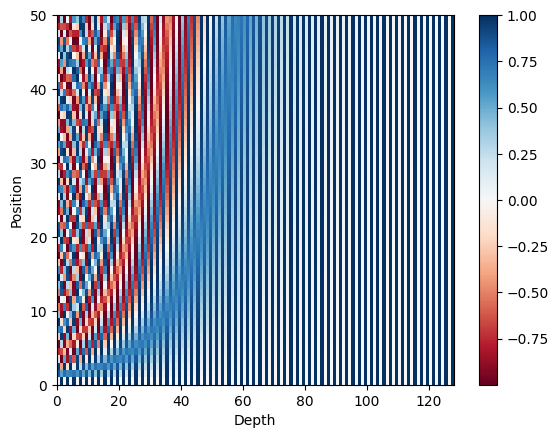

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create an instance of the PositionalEncoding class
max_length = 50
embedding_dim = 128

# Create an instance of the PositionalEncoding class
pos_encoding = PositionalEncoding(max_length, embedding_dim)

# Convert the positional encoding tensor to a numpy array
pos_encoding_matrix = pos_encoding.positional_encoding.detach().numpy()

# Plotting the heatmap of positional encodings
plt.pcolormesh(pos_encoding_matrix, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

이제 전체 embedding값을 완성해봅시다

In [ ]:
class TransformerEmbedding(nn.Module):
    """
    Embedding layer for transformer models that combines token embeddings with positional encodings.

    This class implements an embedding layer specific to transformer architectures, combining learned token embeddings with fixed (or learned) positional encodings.
    The token embeddings convert token indices into embeddings and the positional encodings provide additional context about the position of tokens within the sequence, which is crucial for models without recurrent structure.

    Attributes:
    tok_emb (TokenEmbedding): A module to convert token indices into embeddings.
    pos_emb (PositionalEncoding): A module to generate positional encodings for tokens.

    Parameters:
    vocab_size (int): The size of the vocabulary.
    embedding_dim (int): The dimensionality of the embeddings.
    max_len (int): The maximum length of the input sequences. Note that `max_len` should match the maximum length expected in the positional encoding module.

    Methods:
    forward(x): Computes the embeddings by summing token and positional embeddings.
    """

    def __init__(self, vocab_size, embedding_dim, max_len):

        super(TransformerEmbedding, self).__init__()
        self.tok_emb = TokenEmbedding(vocab_size, embedding_dim)
        self.pos_emb = PositionalEncoding(max_len, embedding_dim)

    def forward(self, x):
        """
        Computes the embeddings for input indices by summing token and positional embeddings.

        Parameters:
        x (torch.Tensor): The input tensor containing token indices.

        Returns:
        torch.Tensor: The tensor containing combined embeddings which are the sum of token and positional embeddings.
        """
        # input x: (batch_size, sequence_length)
        # output: (batch_size, sequence_length, embedding_dim) for encode layer

        tok_emb = self.tok_emb(x)
        pos_emb = self.pos_emb(x)

        return tok_emb + pos_emb

## 2-2. Attention in Transformer


### 2-2-1. Scaled Dot Product Attention

![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/scale_dot_product_attention.png)

Self-Attention 메커니즘 중 하나로, 입력 시퀀스 내의 단어들 간의 관계를 학습하는 데 사용되는 기술입니다. 입력 시퀀스의 모든 단어를 서로 다른 관련성 가중치로 가중 평균하여 표현하는 방법입니다.

[계산 방법]

1) 입력 시퀀스를 Query(Q), Key(K), Value(V)로 세 가지 선형 변환을 거칩니다. 이를 통해 각각의 단어들을 차원을 다르게하여 쿼리, 키, 밸류로 표현합니다.

2) 쿼리(Q)와 키(K) 간의 유사도를 계산합니다. 일반적으로는 내적(dot-product)을 사용하여 유사도를 계산합니다.

3) 유사도를 키(K)의 차원 수로 나누어, 스케일링(scaling)을 적용합니다. 스케일링은 유사도를 안정적으로 유지하기 위해 사용됩니다.

4) 계산된 유사도를 소프트맥스(softmax) 함수를 통해 정규화합니다. 이로써 입력 시퀀스 내의 모든 단어들 간의 관련성 가중치를 얻을 수 있습니다.

5) 정규화된 가중치와 키(K)에 대응하는 밸류(V)를 가중 평균하여 Self-Attention 값을 얻습니다. 이는 입력 시퀀스 내의 각 단어에 대해 중요도를 반영한 표현을 얻는 것을 의미합니다.

Scaled Dot-Product Attention은 행렬 연산을 통해 병렬적으로 처리되기 때문에 다수의 단어들 간의 관계를 빠르게 계산할 수 있습니다. 이로 인해 Transformer 모델은 긴 시퀀스에 대해서도 비교적 높은 효율성을 유지할 수 있게 됩니다.

In [ ]:
class ScaledDotProductAttention(nn.Module):
    """
    Implements the scaled dot-product attention mechanism.

    This class provides a scaled dot-product attention mechanism as used in transformer models.
    It scales the dot products by the square root of the dimension of the attention keys, which helps in stabilizing gradients during backpropagation.


    Attributes:
    embedding_dim (int): The dimensionality of input embeddings.
    attention_dim (int): The dimensionality of the attention space, typically the same as `embedding_dim`.
    scale (torch.Tensor): The scaling factor for the attention scores, computed as the square root of `attention_dim`.

    Parameters:
    embedding_dim (int): Dimensionality of the input embeddings.
    attention_dim (int): Size of the attention keys and values.

    Methods:
    forward(query, key, value, mask=None): Computes the attention values based on the provided query, key, and value tensors. Optional masking can be applied.
    """

    def __init__(self, embedding_dim, attention_dim):
        super(ScaledDotProductAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.attention_dim = attention_dim

        # scaling factor 정의
        self.scale = torch.sqrt(torch.tensor(attention_dim, dtype=torch.float32))

    def forward(self, query, key, value, mask=None):
        """
        Computes the attention values using scaled dot-product attention mechanism.

        Parameters:
        query (torch.Tensor): Query tensor of shape (batch_size, num_heads, sequence_length, attention_dim).
        key (torch.Tensor): Key tensor of shape (batch_size, num_heads, sequence_length, attention_dim).
        value (torch.Tensor): Value tensor of shape (batch_size, num_heads, sequence_length, attention_dim).
        mask (torch.Tensor, optional): The mask's elements are 0 where the attention should be masked, and 1 otherwise.

        Returns:
        attention_value (torch.Tensor): The resulting tensor after applying attention, of shape (batch_size, num_heads, sequence_length, attention_dim).

        Notes:
        - The mask is applied to the attention scores before softmax, setting masked positions to a large negative value to minimize their effect in the softmax step.
        """
        # ScaledDotProductAttention 구현
        # attention_score shape (batch_size, num_heads, sequence_length, sequence_length)
        key = key.transpose(-2, -1)
        attention_score = torch.matmul(query, key) / self.scale

        # masked_fill 함수
        # attention_score의 결과에서 mask가 0인 부분에 -1e10이라는 값을 채워넣는다.
        if mask is not None:
            attention_score = attention_score.masked_fill(mask == 0, -1e10)

        # 가중치와 최종 attention value 구현
        attention_distribution = F.softmax(attention_score, dim=3)
        attention_value = torch.matmul(attention_distribution, value) # (batch_size, num_heads, sequence_length, attention_dim)

        return attention_value

### 4-2-2. MultiHeadAttention


![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/multi_head_attention.png)

마찬가지로 Self-Attention 메커니즘 중 하나로, 입력 시퀀스의 다양한 관점을 캡처하기 위해 여러 개의 Attention 헤드를 병렬로 사용하는 기법입니다. Self-Attention 레이어를 여러 개의 헤드로 나누고, 각 헤드에서 병렬로 Self-Attention을 수행하여 다양한 정보를 효과적으로 추출합니다.

[계산 방법]

1) 입력 시퀀스를 여러 개의 서로 다른 헤드로 분리합니다. 각 헤드는 별도의 Query(Q), Key(K), Value(V) 선형 변환을 적용합니다. 이를 통해 서로 다른 특성을 가진 Query, Key, Value를 추출할 수 있습니다.

2) 각 헤드에서는 Scaled Dot-Product Attention을 사용하여 서로 다른 관점으로 입력 시퀀스의 단어들 간의 관계를 학습합니다. 각 헤드는 서로 다른 관점의 정보를 캡처하고, 다양한 종류의 패턴을 인식할 수 있게 됩니다.

3) 계산된 Self-Attention 결과를 다시 하나의 행렬로 결합합니다. 이를 통해 서로 다른 헤드의 정보를 종합하여 최종 Self-Attention 결과를 얻을 수 있습니다.

4) 병렬로 동작하는 여러 헤드를 가짐으로써, 모델은 다양한 관점에서 입력 시퀀스를 살펴볼 수 있고, 각 단어에 대해 다양한 특징을 추출하여 보다 풍부한 표현을 얻을 수 있게 됩니다.

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Implements the Multi-Head Attention mechanism.

    This class combines multiple attention heads to allow the model to jointly attend to information from different representation subspaces at different positions.
    The input is transformed into multiple heads, each with its own set of linear transformations for queries, keys, and values, followed by the scaled dot-product attention.
    The outputs of these heads are then concatenated and linearly transformed into the final output.

    Attributes:
    num_heads (int): The number of attention heads.
    embedding_dim (int): The total dimension of the input embeddings.
    attention_dim (int): Dimension of each attention head.

    scaled_dot_product_attention (ScaledDotProductAttention): The attention mechanism used in each head.
    Wq (nn.Linear): Linear transformation for query vectors.
    Wk (nn.Linear): Linear transformation for key vectors.
    Wv (nn.Linear): Linear transformation for value vectors.
    Wo (nn.Linear): Linear transformation that combines outputs from all attention heads.

    Parameters:
    embedding_dim (int): Total dimensionality of the input embeddings.
    num_heads (int): Number of heads to split the embedding_dim into.
    """

    def __init__(self, embedding_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        # 변수 정의
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.attention_dim = self.embedding_dim // self.num_heads

        self.scaled_dot_product_attention = ScaledDotProductAttention(self.embedding_dim, self.attention_dim)
        self.Wq = nn.Linear(self.embedding_dim, self.embedding_dim)
        self.Wk = nn.Linear(self.embedding_dim, self.embedding_dim)
        self.Wv = nn.Linear(self.embedding_dim, self.embedding_dim)
        self.Wo = nn.Linear(self.embedding_dim, self.embedding_dim)

    ######## 추가 ########
    def transpose_qkv(self, x):
      x = x.reshape(x.shape[0], x.shape[1], self.num_heads, self.attention_dim)
      x = x.transpose(1, 2)
      return x.to(x.device)

    def forward(self, query, key, value, mask=None):
        """
        Computes the output of the Multi-Head Attention layer.

        Parameters:
        query (torch.Tensor): Query tensor of shape (batch_size, sequence_length, embedding_dim).
        key (torch.Tensor): Key tensor of shape (batch_size, sequence_length, embedding_dim).
        value (torch.Tensor): Value tensor of shape (batch_size, sequence_length, embedding_dim).
        mask (torch.Tensor, optional): Mask tensor (batch_size, 1, sequence_length, sequence_length) to exclude certain positions from attention.

        Returns:
        output (torch.Tensor): The resulting tensor after applying multi-head attention, of shape (batch_size, sequence_length, embedding_dim).
        """
        batch_size = query.size(0)
        sequence_length = query.size(1)

        # MultiHeadAttention 계산 구현
        # Transforming the input and applying the attention mechanism for each head
        # query, key, value will have shape (batch_size, num_heads, sequence_length, attention_dim) after transformation

        query = self.transpose_qkv(query)
        key = self.transpose_qkv(key)
        value = self.transpose_qkv(value)

        # Calculating attention values
        attention_values = self.scaled_dot_product_attention(query, key, value, mask) # (batch_size, num_heads, sequence_length, attention_dim)
        attention_values = attention_values.transpose(1, 2).reshape(batch_size, sequence_length, self.num_heads * self.attention_dim)

        # Combining attention outputs from all heads
        output = self.Wo(attention_values)

        return output


## 2-3. FeedForwardNeuralNetwork

가장 간단한 형태의 FeedForward Network의 형태로 설명을 읽고 순서에 맞추어 구현해주시면 되겠습니다.
![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/feed-forward.png)

Position-wise Feed-Forward Network은 각 위치(position)별로 독립적으로 적용되는 두 개의 선형 변환과 활성화 함수로 구성되는 네트워크입니다. 모델의 비선형성을 증가시키고, 입력 시퀀스의 각 위치에서 다양한 특징을 추출하는 데 도움이 됩니다.

[설명]

1) 입력 시퀀스의 각 위치별로, 먼저 하나의 선형 변환을 적용합니다. 이는 입력 시퀀스의 각 위치별로 입력 차원을 다른 차원으로 매핑하는 역할을 합니다.

2) 활성화 함수로 주로 ReLU(Rectified Linear Unit)가 사용됩니다. 이 활성화 함수는 비선형성을 도입하여 모델이 더 복잡한 관계를 학습할 수 있도록 도와줍니다.

3) 두 번째 선형 변환을 적용합니다. 이는 ReLU 활성화 함수를 통과한 결과를 다시 다른 차원으로 매핑하여 최종적인 출력 차원을 얻는 역할을 합니다.

- PoswiseFeedForwardNet은 다음과 같은 수식으로 표현될 수 있습니다:

- $PoswiseFeedForwardNet(x)=ReLU(xW_1​ +b_1​)W_2​ +b_2
​ $

여기서
$x$는 입력 시퀀스의 각 위치에 대한 벡터를 나타내고, $W_1$과 $b_1$은 첫 번째 선형 변환의 가중치 행렬과 편향 벡터, $W_2$와 $b_2$는 두 번째 선형 변환의 가중치 행렬과 편향 벡터를 나타냅니다.

모델이 입력 시퀀스의 각 위치에서 다양한 특징을 추출하고, 비선형성을 도입하여 더 풍부한 표현을 학습할 수 있도록 합니다.

In [ ]:
class FeedForwardNeuralNetwork(nn.Module):
    """
    A simple feed-forward neural network module using PyTorch's nn.Module as a base class.

    This class implements a feed-forward neural network with one hidden layer. It applies
    a linear transformation followed by a ReLU activation and dropout on the input,
    then another linear transformation to produce the output.

    Attributes:
        W1 (nn.Linear): The first linear transformation layer from input dimension to hidden layer dimension.
        W2 (nn.Linear): The second linear transformation layer from hidden layer dimension back to the input dimension.
        relu (nn.ReLU): The ReLU activation function that introduces non-linearity after the first linear transformation.
        dropout (nn.Dropout): The dropout layer that randomly zeroes some of the elements of the input tensor with
            probability p during training, which helps prevent overfitting.

    Parameters:
        embedding_dim (int): The dimensionality of the input and output embeddings.
        feed_forward_dim (int): The dimensionality of the hidden layer.
        drop_prob (float): The dropout probability for the dropout layer.

    Methods:
    forward(inputs): Processes the input through the two linear layers and ReLU activation, producing the transformed output.
    """

    def __init__(self, embedding_dim, feed_forward_dim, drop_prob):
        super(FeedForwardNeuralNetwork, self).__init__()
        # 변수 정의
        self.W1 = nn.Linear(embedding_dim, feed_forward_dim)
        self.W2 = nn.Linear(feed_forward_dim, embedding_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, inputs):
        """
        Computes the output of the feed-forward neural network.

        Parameters:
        inputs (torch.Tensor): The input tensor of shape (batch_size, sequence_length, embedding_dim).

        Returns:
        outputs (torch.Tensor): The output tensor after processing through the feed-forward neural network, matching the shape of the input tensor (batch_size, sequence_length, embedding_dim).
        """
        # FeedForwardNeuralNetwork 구현
        outputs = self.W2(self.relu(self.W1(inputs)))

        return outputs

아래 `LayerNormalization` class는 이미 구현되어 있습니다!

In [ ]:
class LayerNormalization(nn.Module):
    def __init__(self, num_features):
        super(LayerNormalization, self).__init__()
        self.layer_norm = nn.LayerNorm(num_features)

    def forward(self, x):
        x = self.layer_norm(x)
        return x

## 2-4. Padding Mask
Padding Mask를 구하기 위한 함수 입니다.

Transformer 모델은 입력 시퀀스의 길이가 가변적일 수 있기 때문에, 입력 시퀀스의 길이를 일정하게 맞추기 위해 패딩(Padding)을 사용합니다. 패딩은 특정 값을 사용하여 시퀀스의 길이를 일정하게 맞추는 기술로, 주로 0과 같은 값이 사용됩니다.

하지만 입력 시퀀스의 길이가 다르면, 이로 인해 Masking이 필요합니다. Masking은 패딩된 부분에 대해서는 모델이 실제로 입력값으로 처리하지 않도록 막는 것을 의미합니다. 이렇게 함으로써 모델이 패딩된 부분을 무시하고 실제 입력값에만 집중하여 처리할 수 있게 됩니다.

"create_padding_mask_for_attention" 함수는 이러한 패딩 부분에 대한 Mask를 구하는 함수로, 주어진 입력 시퀀스에서 패딩된 위치에 0으로 채워진 마스크를 생성합니다. 이렇게 생성된 마스크는 실제 입력값이 있는 위치는 1로 표시되고, 패딩된 위치는 0으로 표시됩니다.

즉, 데이터로더에서 각 batch 별로 가장 긴 길이에 맞추어 이미 padding을 했습니다. mask는 각 input에서 padding된 위치를 알려주는 역할을 합니다.

Ex) [55, 43, 102, 43, 0, 0, 0] ➡ [1, 1, 1, 1, 0, 0, 0]

이렇게 생성된 마스크는 attention score를 구할 때, mask에서 0에 해당하는 부분을 굉장히 작은 음수값으로 설정해 사실상 attention score 연산에서 제외될 수 있도록 도와줍니다. 이 때, 사용하는 함수는 'masked_fill" 함수입니다.

In [ ]:
def create_padding_mask_for_attention(batch: Tensor, pad_idx: int) -> Tensor:
    """
    Creates a square binary padding mask for the attention mechanism, where the mask indicates
    whether each token in the input batch is a padding token or not. This mask can be used
    in attention mechanisms to prevent attention to padding tokens.

    This function assumes that the input tensor `batch` is a 2D tensor representing sequences of
    tokens, where each element in the tensor is a token ID. The mask is constructed such that
    it has dimensions suitable for multi-head attention, adding two additional dimensions
    to cater to the heads and to square the mask.

    Parameters:
    - batch (Tensor): A 2D tensor of shape (batch_size, sequence_length), where each entry is a token ID.
    - pad_idx (int): The token ID used to identify padding tokens in the batch.

    Returns:
    - Tensor: A 4D binary mask tensor of shape (batch_size, 1, sequence_length, sequence_length).
              This tensor is placed on the same device as the input tensor `batch`.
              A value of `True` at a position indicates that the corresponding token
              is not a padding token and should be attended to, while `False` indicates
              it is a padding token and should not be attended to in the attention layers.

    """
    padding_mask = (batch != pad_idx)
    sequence_length = batch.size(1)

    # padding mask를 생성하는 함수
    padding_mask = padding_mask.unsqueeze(1).repeat(1, sequence_length, 1)
    padding_mask = padding_mask.unsqueeze(1)

    return padding_mask.to(batch.device)

## 2-5. Encoder Layer
**Encoder Layer를 직접 구현해봅니다!**

앞 서 구현한 클래스를 바탕으로 Encoder Layer의 순서에 맞게 Encoder Layer를 구현해주시면 됩니다. 아래 이미지와 강의자료를 참고해주세요!

Encoder Layer는 입력 시퀀스의 단어들을 인코딩하여 중간 표현을 생성하는 역할을 합니다.

1) 입력 단어들에 대해 주변 단어들과의 관련성을 고려한 Self-Attention을 수행하여 풍부한 문맥 정보를 추출합니다.

2) Feed-Forward Network를 통해 비선형성을 도입하고 다양한 특징을 추출합니다.

3) Layer 간 잔차 연결과 Layer Normalization으로 Gradient Vanishing 문제를 완화하고, 모델 학습을 돕습니다.

![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/encoder.png)


In [ ]:
class EncoderLayer(nn.Module):
    """
    Represents a single layer of a Transformer Encoder.

    This layer applies multi-head self-attention followed by position-wise feed-forward networks on the input sequence.
    It incorporates dropout and layer normalization at both the attention and feed-forward stages to stabilize and regularize the training process.

    Attributes:
        multi_head_attention (MultiHeadAttention): A multi-head attention mechanism.
        norm1 (LayerNormalization): Layer normalization applied after the attention mechanism.
        dropout1 (nn.Dropout): Dropout applied after the attention mechanism.
        feed_forward_neural_network (FeedForwardNeuralNetwork): A position-wise feed-forward neural network.
        norm2 (LayerNormalization): Layer normalization applied after the feed-forward network.
        dropout2 (nn.Dropout): Dropout applied after the feed-forward network.

    Parameters:
        embedding_dim (int): The size of the input feature dimension.
        feed_forward_dim (int): The dimensionality of the feed-forward network's inner layer.
        num_heads (int): The number of heads in the multi-head attention mechanism.
        drop_prob (float): The dropout probability for the dropout layers.

    Methods:
        forward(x, padding_mask): Defines the computation performed at every call. It takes inputs `x` and `padding_mask`, applies the attention and feed-forward mechanisms, and returns the transformed output.
    """
    def __init__(self, embedding_dim, feed_forward_dim, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(embedding_dim, num_heads)
        self.norm1 = LayerNormalization(embedding_dim)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.feed_forward_neural_network = FeedForwardNeuralNetwork(embedding_dim, feed_forward_dim, drop_prob=drop_prob)
        self.norm2 = LayerNormalization(embedding_dim)
        self.dropout2 = nn.Dropout(p=drop_prob)


    def forward(self, x, padding_mask):
        """
      Process the input tensor through the encoder layer to refine the representations with attention and feed-forward networks.

      Parameters:
          x (Tensor): The input tensor to the encoder layer, which should have the shape
                      (batch_size, sequence_length, embedding_dim), representing a batch of sequences with embeddings.
          padding_mask (Tensor): The padding mask tensor, shaped (batch_size, 1, sequence_length, sequence_length),
                                used in the multi-head attention to prevent attention to padding positions within the sequence.

      Returns:
          Tensor: The output tensor from the encoder layer, maintaining the shape (batch_size, sequence_length, embedding_dim).
                  This output contains the refined embeddings after applying multi-head attention, dropout, and normalization steps.
      """

        # encoder layer
        input_x = x
        x = self.multi_head_attention(x, x, x, padding_mask)
        x = self.dropout1(x)
        x += input_x
        x = self.norm1(x)

        attention_x = x
        x = self.feed_forward_neural_network(x)
        x = self.dropout2(x)
        x += attention_x
        x = self.norm2(x)

        return x.to(x.device)


**Encoder Layer를 구현했다면 전체 Transformer Encoder의 구조를 구현해봅시다.**

해당 Encoder가 전체 input부터 output까지 출력하는 전체 구조입니다. 역시나 앞 서 구현한 클래스들을 바탕으로 구현해주시면 되고 Transformer Encoder에는 Encoder Layer(Block)이 여러 개(논문 기준 6개)가 포함된다고 설명드렸습니다. 이 점에 유의해서 구현해주세요!

1) 입력에 대한 Position 값을 구하기: 각 단어의 상대적인 위치를 나타내는 Positional Encoding을 계산합니다.

2) Input Embedding과 Position Embedding 더하기: 입력 시퀀스의 단어들을 임베딩하여 벡터로 표현한 후, Positional Encoding을 더합니다. 이를 통해 입력 시퀀스의 단어들은 고유한 위치 정보를 가진 임베딩으로 변환됩니다.

3) 입력에 대한 Attention Pad Mask 구하기: Self-Attention 레이어에서 패딩 부분에 대한 마스크를 생성합니다. 이렇게 함으로써 모델이 패딩 부분을 무시하고, 실제 입력에만 집중할 수 있도록 돕습니다.

4) for 루프를 돌며 각 layer를 실행하기: 여러 개의 EncoderLayer로 구성된 스택을 순차적으로 거칩니다. 각 EncoderLayer는 입력 시퀀스에 대한 인코딩을 수행하고, 다음 EncoderLayer로 전달하기 위해 중간 결과를 출력합니다.

5) layer의 입력은 이전 layer의 출력 값: 스택의 첫 번째 EncoderLayer를 거칠 때는 이전 layer가 없으므로, Input Embedding과 Position Embedding의 결과가 첫 번째 EncoderLayer의 입력으로 사용됩니다. 이후의 EncoderLayer들은 이전 layer의 출력 값을 입력으로 받아 처리합니다.

이렇게 입력 시퀀스에 대한 인코딩을 위해 Positional Encoding, Self-Attention, Residual Connection 등의 기법을 사용하여 입력 정보를 풍부하게 표현합니다. 이 과정을 여러 번 쌓아 올려서 Encoder를 형성하며, 최종적으로 입력 시퀀스의 문맥 정보를 잘 반영한 중간 표현을 얻습니다.

In [ ]:
class Encoder(nn.Module):
    """
    A Transformer encoder module for processing sequences using multiple encoder layers.

    This class is a PyTorch module that utilizes a stack of transformer encoder layers to process
    input sequences. It first applies positional embeddings using a TransformerEmbedding layer
    before passing the data through multiple transformer encoder layers.

    Attributes:
        transformer_embedding (TransformerEmbedding): An embedding layer that adds position
            embeddings to the token embeddings.
        encoder_layers (nn.ModuleList): A list of encoder layers (instances of EncoderLayer)
            used to process the input data sequentially.

    Args:
        vocab_size (int): The size of the vocabulary (number of unique tokens).
        sequence_length (int): The sequence length of input sequences.
        embedding_dim (int): The dimensionality of token embeddings.
        feed_forward_dim (int): The dimensionality of the feed-forward networks in the encoder layers.
        num_heads (int): The number of attention heads in each encoder layer.
        num_layers (int): The number of encoder layers in the module.

    Methods:
        forward(x, padding_mask):
            Processes input data through the transformer embedding and each encoder layer sequentially.

            Args:
                x (Tensor): The input tensor containing token indices, shape [batch_size, sequence_length].
                padding_mask (Tensor): The padding mask for the input tensor, shape [batch_size, sequence_length].

            Returns:
                Tensor: The output tensor from the final encoder layer, shape [batch_size, sequence_length, embedding_dim].
    """
    def __init__(self, vocab_size, sequence_length, embedding_dim, feed_forward_dim, num_heads, num_layers, drop_prob):
        super(Encoder, self).__init__()

        # 변수 정의
        self.transformer_embedding = TransformerEmbedding(vocab_size, embedding_dim, sequence_length)
        self.encoder_layers = nn.ModuleList([EncoderLayer(embedding_dim, feed_forward_dim, num_heads, drop_prob) for _ in range(num_layers)])

    def forward(self, x, padding_mask):
        x = self.transformer_embedding(x)

        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, padding_mask)

        return x

## 2-6. Encoder를 활용해 Classifier 구현

이번에는 IMDB 데이터셋을 사용하여 영화 리뷰의 감성을 분석해보려 합니다. Transformer Transformer Encoder로 input sentence를 Encoding한 뒤 해당 Encoding을 가장 간단한 classifier에 통과시켜 해당 리뷰가 긍정(1)인지 부정(0)인지를 분류하는 Classification 모델입니다.

In [ ]:
class Classifier(nn.Module):
    def __init__(self, vocab_size, sequence_length, embedding_dim, feed_forward_dim, num_heads, num_layers, drop_prob):
        super(Classifier, self).__init__()
        self.encoder = Encoder(vocab_size, sequence_length, embedding_dim, feed_forward_dim, num_heads, num_layers, drop_prob)

        # classifier를 구현
        # Encoder의 output의 shape: [batch_size, sequence_length, embedding_dim]
        # 구현한 classifier는 아래에 있는 IMDB 데이터셋에 대한 이진 분류 (binary classification)에 활용

        self.classifier = nn.Sequential(
            nn.Dropout(drop_prob),
            nn.Linear(embedding_dim,  embedding_dim),
            nn.ReLU(),
            nn.Dropout(drop_prob),
            nn.Linear(embedding_dim,  1),
        )


    def forward(self, x, padding_mask):
        # Output of encoder shape expected: [batch_size, sequence_length, embedding_dim]
        x = self.encoder(x, padding_mask)
        x = x.mean(dim=1)
        # classifier를 이용해서 output을 계산
        output = self.classifier(x).squeeze(1)
        return output.to(x.device)

## 2-7. Dataset 준비

아래 코드는 torchtext 라이브러리를 활용해 IMDB 영화 리뷰 데이터셋을 준비합니다. Tokenizer를 사용해 텍스트를 토큰으로 분리하고, IMDB 영화 리뷰 데이터셋의 training set을 사용하여 어휘를 구축합니다. 어휘에는 특수 토큰으로 `<unk>`(알 수 없는 토큰)와 `<pad>`(패딩 토큰)가 포함됩니다. Training 및 test 데이터셋은 `random_split` 함수를 사용하여 분할되며, 이는 데이터셋 길이 관련 에러를 방지하기 위해 사용됩니다. 추가적으로, 텍스트를 수치화된 토큰 ID로 변환하는 함수와 라벨을 인코딩하는 함수를 정의하여, 이를 통해 데이터를 모델 학습에 적합한 형태로 전처리합니다. 추가적으로 구현할 부분 없이 그대로 사용하시면 됩니다.

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

# Tokenizer
tokenizer = get_tokenizer('basic_english')

# Building the vocabulary
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# Load the IMDb dataset
train_iter, test_iter = IMDB(split=('train', 'test'))
torch.manual_seed(42)

# random_split을 활용하는 이유는 'TypeError: MapperIterDataPipe instance doesn't have valid length' 를 방지하기 위함이고 특별한 이유는 따로 없습니다.
train_iter, _ = random_split(list(train_iter), [24000, 1000])
test_iter, _ = random_split(list(test_iter), [24000, 1000])

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])
UNK_IDX, PAD_IDX = 0, 1
MAX_SEQ_LENGTH = 512

# Encoding text function
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)[:MAX_SEQ_LENGTH]]
label_pipeline = lambda x: int(x) - 1

아래 코드는 `collate_batch` 함수를 정의하고 `DataLoader`를 만드는 과정을 포함하고 있습니다.

collate_fn은 DataLoader에서 데이터를 불러올 때 데이터 전처리를 할 수 있도록 만들어줍니다. 여기서는 데이터 전처리에 collate_batch 함수를 사용합니다. 이 합수는 label에는 -1을 적용하고, text는 tokenize 후 index로 변환하고, padding을 추가합니다. 이후 label과 text를 tensor 형태로 return 합니다.

In [ ]:
# Data loader collation function with padding and truncation
def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(float(label_pipeline(_label)))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)

    text_list = nn.utils.rnn.pad_sequence(text_list, padding_value=vocab['<pad>'], batch_first=True)
    text_list = text_list[:, :MAX_SEQ_LENGTH]

    return torch.tensor(label_list, dtype=torch.float), text_list


# Create DataLoader for train and test
train_dataloader = DataLoader(train_iter, batch_size=64, drop_last=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_iter, batch_size=64, collate_fn=collate_batch)

## 2-8. Training 및 Evaluation


이제 직접 학습을 해봅시다. `Classifier(vocab_size=len(vocab), sequence_length=MAX_SEQ_LENGTH` 이 부분 제외하고 자유롭게 수정하셔도 됩니다. 원하시면 learning rate scheduler를 사용하셔도 되고 다른 training technique을 사용하셔도 됩니다. 대신 마지막 코드에서 test set에 대한 evaluation 결과 **accuracy가 0.8 이상 나와야 됩니다.**

In [ ]:
from IPython.display import display
from tqdm import tqdm, tqdm_notebook, trange
import wget


# embedding_dim, feed_forward_dim, num_heads, num_layers, drop_prob 값 정의
# vocab_size=len(vocab)과 sequence_length=MAX_SEQ_LENGTH 부분은 수정하지 말것.
model = Classifier(vocab_size=len(vocab), sequence_length=MAX_SEQ_LENGTH, embedding_dim=512,
                   feed_forward_dim=1024, num_heads=8, num_layers=6,
                   drop_prob=0.1).to(device) #논문기반 설정

class LRScheduler: # 임의로 구현하니 성능 구려서 논문대로 lr 설정하기 위한 scheduler
    def __init__(self, optimizer, model_dim, warmup_steps=4000):
        self.optimizer = optimizer
        self.model_dim = model_dim
        self.warmup_steps = warmup_steps
        self.step_num = 0

    def step(self):
        self.step_num += 1
        lr = self.compute_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

    def compute_lr(self):
        temp1 = self.step_num**(-0.5)
        temp2 = self.step_num * (self.warmup_steps**(-1.5))
        return (self.model_dim ** (-0.5)) * min(temp1, temp2)

def train(dataloader):
    model.train()
    total_loss = 0
    # Wrap the dataloader with tqdm for a progress bar
    progress_bar = tqdm(dataloader, desc="Training", leave=True)
    for label, text in progress_bar:
        label, text = label.to(device), text.to(device)
        optimizer.zero_grad()

        # Assuming create_padding_mask_for_attention is defined elsewhere
        src_padding_mask = create_padding_mask_for_attention(text, PAD_IDX)

        output = model(text, src_padding_mask).to(device)
        loss = criterion(output, label)
        loss.backward()

        # Gradient clipping은 사용해도 되고 안해도 된다
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        # Update progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())

    return total_loss / len(dataloader)

# Loss function과 optimizer 정의
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9) # 논문기반
scheduler = LRScheduler(optimizer, 512)

# Epoch 값 설정
epochs = 10
for epoch in range(epochs):
    train_loss = train(train_dataloader)
    print(f'Epoch {epoch+1}, Train loss: {train_loss:.4f}')


Training: 100%|██████████| 375/375 [05:55<00:00,  1.06it/s, loss=0.607]


Epoch 1, Train loss: 0.6528


Training: 100%|██████████| 375/375 [05:54<00:00,  1.06it/s, loss=0.49] 


Epoch 2, Train loss: 0.4813


Training: 100%|██████████| 375/375 [05:54<00:00,  1.06it/s, loss=0.56] 


Epoch 3, Train loss: 0.4107


Training: 100%|██████████| 375/375 [05:53<00:00,  1.06it/s, loss=0.447]


Epoch 4, Train loss: 0.3556


Training: 100%|██████████| 375/375 [05:52<00:00,  1.06it/s, loss=0.586]


Epoch 5, Train loss: 0.3153


Training: 100%|██████████| 375/375 [05:51<00:00,  1.07it/s, loss=0.55] 


Epoch 6, Train loss: 0.2775


Training: 100%|██████████| 375/375 [05:50<00:00,  1.07it/s, loss=0.68]  


Epoch 7, Train loss: 0.2608


Training: 100%|██████████| 375/375 [05:50<00:00,  1.07it/s, loss=0.415] 


Epoch 8, Train loss: 0.2493


Training: 100%|██████████| 375/375 [05:50<00:00,  1.07it/s, loss=0.348] 


Epoch 9, Train loss: 0.2172


Training: 100%|██████████| 375/375 [05:49<00:00,  1.07it/s, loss=0.296] 

Epoch 10, Train loss: 0.2103


Evaluation 결과 accuracy가 0.8 이상 나오면 통과입니다!

In [ ]:
def evaluate(dataloader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed
        progress_bar = tqdm(dataloader, desc="Evaluation", leave=True)
        for label, text in progress_bar:
            label, text = label.to(device), text.to(device)
            src_padding_mask = create_padding_mask_for_attention(text, PAD_IDX)

            output = model(text, src_padding_mask)
            loss = criterion(output, label)
            total_loss += loss.item()

            # Convert model output to predicted labels
            # Assuming binary classification with a sigmoid output layer
            prediction = (torch.sigmoid(output) > 0.5).float()
            correct += (prediction == label).sum().item()
            total += label.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy


# Assuming model, criterion, and device are defined
test_loss, test_accuracy = evaluate(test_dataloader)
print(f'Test Accuracy: {test_accuracy:.4f}')

Evaluation: 100%|██████████| 375/375 [02:12<00:00,  2.82it/s]

Test Accuracy: 0.8360
